In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
train1 = pd.read_csv('./data/atec_nlp_sim_train_add.csv', sep='\t', header=None, encoding='utf-8')
train1.columns = ['id', 'question1', 'question2', 'is_duplicate']
train2 = pd.read_csv('./data/atec_nlp_sim_train.csv', sep='\t', header=None, encoding='utf-8')
train2.columns = ['id', 'question1', 'question2', 'is_duplicate']
train = train1.append(train2)

In [12]:
train.head(5)

,id,question1,question2,is_duplicate
0,1,为何我无法申请开通花呗信用卡收款,支付宝开通信用卡花呗收款不符合条件怎么回事,1
1,2,花呗分期付款会影响使用吗,花呗分期有什么影响吗,0
2,3,为什么我花呗没有临时额度,花呗没有临时额度怎么可以负,0
3,4,能不能开花呗老兄,花呗逾期了还能开通,0
4,5,我的怎么开通花呗收钱,这个花呗是个什么啥？我没开通 我怎么有账单,0


正例个数： 18685
负例个数： 83792
正例所占比例： 0.1823335968070884
负例所占比例： 0.8176664031929116


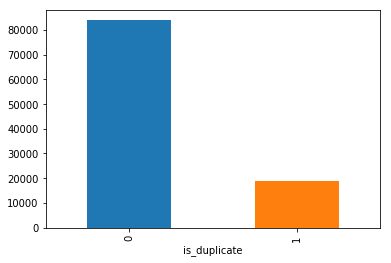

In [8]:
labels = train['is_duplicate'].values
nums_1 = len(train[labels == 1])
nums_0 = len(train[labels == 0])
print('正例个数：', nums_1)
print('负例个数：', nums_0)
print('正例所占比例：', nums_1 / (nums_0 + nums_1))
print('负例所占比例：', nums_0 / (nums_0 + nums_1))
train.groupby("is_duplicate")['id'].count().plot.bar()    # 正负样例分布图

In [8]:
import jieba
jieba.load_userdict('./data/jieba_dict')
def jiebaCut(sentence):
    seg_sent = jieba.cut(sentence, cut_all=False)
    sent = [word for word in seg_sent]
    return sent

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.689 seconds.
Prefix dict has been built succesfully.


In [9]:
def wordCut(sentence):
    # 将句子分成单个字
    return [word for word in sentence]

In [10]:
# 特征一：
# 计算（s1的字同时在s2中也出现和s2的字同时在s1中也出现）的比例
def shared_word_proportion(row):
    q1words = {}
    q2words = {}
    for word in wordCut(row['question1']):
        q1words[word] = 1
    for word in wordCut(row['question2']):
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'shared word proportion')

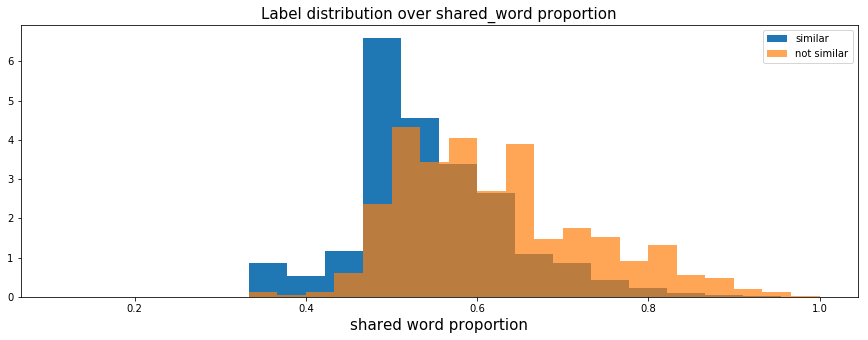

In [11]:
plt.figure(figsize=(15, 5))
shared_word_match = train.apply(shared_word_proportion, axis=1, raw=True)
plt.hist(shared_word_match[train['is_duplicate'] == 0], bins=20, normed=True, label='similar')
plt.hist(shared_word_match[train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='not similar')
plt.legend()
plt.title('Label distribution over shared_word proportion', fontsize=15)
plt.xlabel('shared word proportion', fontsize=15)

In [12]:
# 将所有文本连到一起
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
print(len(train))
print(len(train_qs))

102477
204954


In [13]:
# 特征二： TF/IDF
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = wordCut("".join(train_qs))
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [14]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('呗', 4.523597345553078e-06), ('花', 6.210215804999224e-06), ('么', 1.0714897994171096e-05), ('还', 1.110494169905608e-05), ('借', 1.252740369558409e-05), ('我', 1.2980943974245807e-05), ('款', 1.383087604768886e-05), ('的', 1.4063115261292682e-05), ('了', 1.4994976682811259e-05), ('用', 1.595277977187525e-05)]

Least common words and weights: 


[('貸', 9.998000399920016e-05),
 ('囗', 9.998000399920016e-05),
 ('宵', 9.998000399920016e-05),
 ('兄', 9.998000399920016e-05),
 ('牛', 9.998000399920016e-05),
 ('恼', 9.998000399920016e-05),
 ('擅', 9.998000399920016e-05),
 ('诺', 9.998000399920016e-05),
 ('伦', 9.998000399920016e-05),
 ('映', 9.998000399920016e-05)]

In [15]:
def shared_word_tfidf(row):
    q1words = {}
    q2words = {}
    for word in wordCut(row['question1']):
        q1words[word] = 1
    for word in wordCut(row['question2']):
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'shared word TF/IDF')

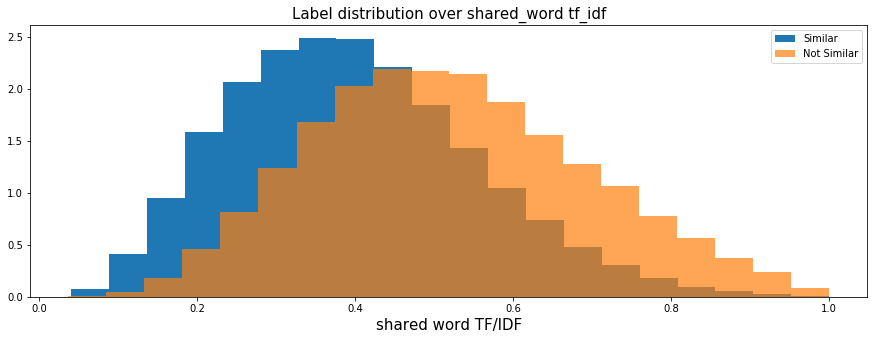

In [16]:
plt.figure(figsize=(15, 5))
tfidf_shared_word_match = train.apply(shared_word_tfidf, axis=1, raw=True)
plt.hist(tfidf_shared_word_match[train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Similar')
plt.hist(tfidf_shared_word_match[train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Not Similar')
plt.legend()
plt.title('Label distribution over shared_word tf_idf', fontsize=15)
plt.xlabel('shared word TF/IDF', fontsize=15)

In [17]:
# The AUC metric is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(train['is_duplicate'], shared_word_match))
print('   TFIDF AUC:', roc_auc_score(train['is_duplicate'], tfidf_shared_word_match.fillna(0)))

Original AUC: 0.6997996619328649
   TFIDF AUC: 0.6998653645284174


In [18]:
# 特征三：两个句子长度差值（效果不好）
def length_dif(row):
    len_s1 = len(wordCut(row['question1']))
    len_s2 = len(wordCut(row['question2']))
    len_dif = abs(len_s1 - len_s2)
    return len_dif

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'length difference')

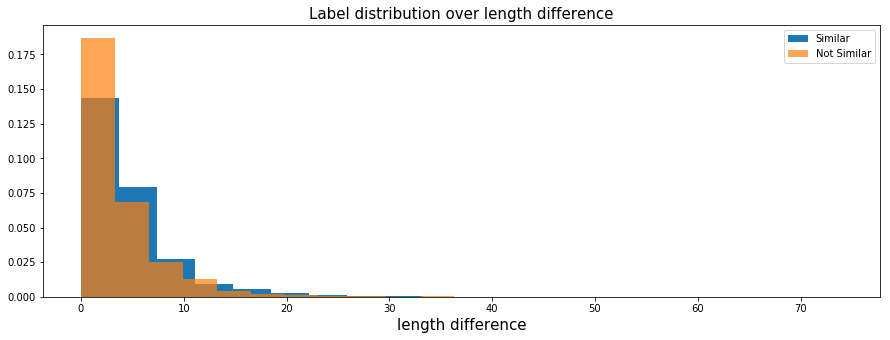

In [19]:
plt.figure(figsize=(15, 5))
length_dif_match = train.apply(length_dif, axis=1, raw=True)
plt.hist(length_dif_match[train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Similar')
plt.hist(length_dif_match[train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Not Similar')
plt.legend()
plt.title('Label distribution over length difference', fontsize=15)
plt.xlabel('length difference', fontsize=15)

In [20]:
# 特征三： jaccard系数
def jaccard_similarity(row):
    s1 = wordCut(row['question1'])
    s2 = wordCut(row['question2'])
    intersection = set(s1).intersection(set(s2))
    union = set(s1).union(set(s2))
    return len(intersection)/len(union)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'jaccard coefficient')

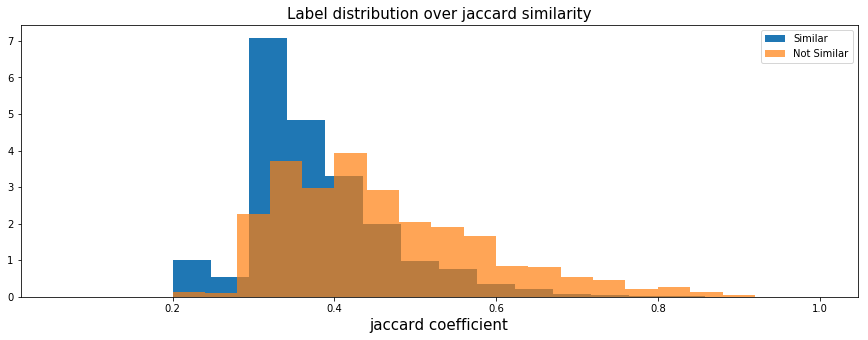

In [21]:
plt.figure(figsize=(15, 5))
jaccard_similarity_match = train.apply(jaccard_similarity, axis=1, raw=True)
plt.hist(jaccard_similarity_match[train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Similar')
plt.hist(jaccard_similarity_match[train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Not Similar')
plt.legend()
plt.title('Label distribution over jaccard similarity', fontsize=15)
plt.xlabel('jaccard coefficient', fontsize=15)

In [29]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [30]:
x_train = pd.DataFrame()
x_train['shared_word_match'] = shared_word_match
x_train['tfidf_shared_word_match'] = tfidf_shared_word_match
x_train['jaccard_similarity_match'] = jaccard_similarity_match
y_train = train['is_duplicate'].values

In [31]:
len(x_train)

102477

In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, train_size=0.9, random_state=4242)

In [33]:
print(len(x_train))
print(len(x_valid))

92229
10248


In [35]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683906	valid-logloss:0.684036
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.608851	valid-logloss:0.610137
[20]	train-logloss:0.556862	valid-logloss:0.559112
[30]	train-logloss:0.519989	valid-logloss:0.523146
[40]	train-logloss:0.493556	valid-logloss:0.497464
[50]	train-logloss:0.474481	valid-logloss:0.479035
[60]	train-logloss:0.460661	valid-logloss:0.465704
[70]	train-logloss:0.450644	valid-logloss:0.456122
[80]	train-logloss:0.443381	valid-logloss:0.449253
[90]	train-logloss:0.438125	valid-logloss:0.444293
[100]	train-logloss:0.43433	valid-logloss:0.440793
[110]	train-logloss:0.431579	valid-logloss:0.438314
[120]	train-logloss:0.429602	valid-logloss:0.436568
[130]	train-logloss:0.428171	valid-logloss:0.435394
[140]	train-logloss:0.427129	valid-logloss:0.434522
[150]	train-logloss:0.426356	valid-logloss:0.433937
[160]	train-logloss:0.425781	

In [ ]:
# 特征四： 将上面三个特征中的字换成对应的拼音或词性，然后用拼音或词性计算得到相同的特征
# 注： 用停用词表去掉“蚂蚁”二字，jieba的userdict中标注上对应词性

In [196]:
predict = bst.predict(x_valid.values)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'